In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from numpy.lib.recfunctions import repack_fields
from numpy.lib.stride_tricks import as_strided

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# np.set_printoptions(threshold=np.inf)
plt.style.use('ggplot')

## Read Dataset

In [2]:
usecols = np.array(['HUMI', 'PRES', 'Iws', 'Iprec', 'PM_US_Post'])
n_feature = usecols[:-1].shape[0]
labels = np.array([0, 1, 2])
n_classes = labels.shape[0]

recs = []

for i in os.listdir('dataset/'):
    fname = 'dataset/{}'.format(i)
    recs.append(np.genfromtxt(fname,
                    delimiter=',',
                    names=True,
                    dtype=np.float64,
                    usecols=usecols,
                    )
            )
    
recs.__len__()

5

## Covent Label

In [3]:
for rec in recs:
    rec['PM_US_Post'][rec['PM_US_Post'] < 10] = labels[0]
    rec['PM_US_Post'][(rec['PM_US_Post'] <= 25) & (rec['PM_US_Post'] >= 10)] = labels[1]
    rec['PM_US_Post'][rec['PM_US_Post'] > 25] = labels[2]

recs.__len__()

5

## Drop Duplicate

In [4]:
for i in range(recs.__len__()):
    recs[i] = np.unique(recs[i], axis=0)

recs.__len__()

5

## Drop Label NaN

In [5]:
for i in range(len(recs)):
    recs[i] = recs[i][~np.isnan(recs[i]['PM_US_Post'])]

recs.__len__()

5

## Visualization

In [6]:
rec_view = np.concatenate(recs)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


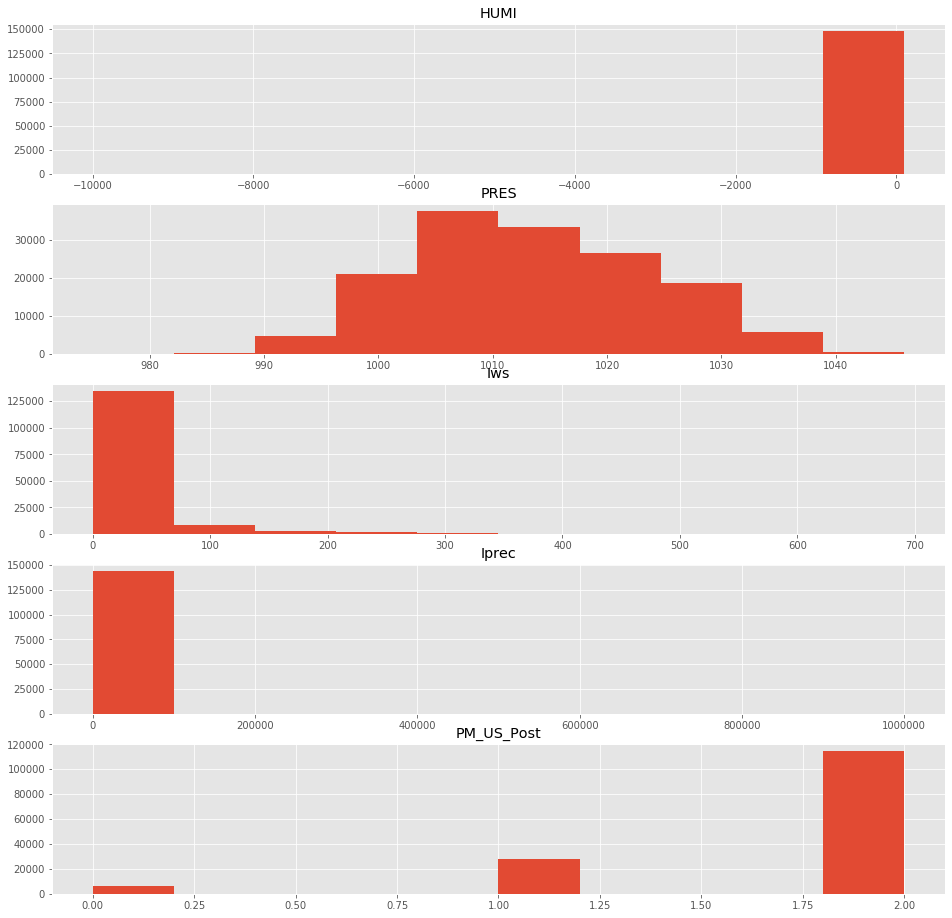

In [7]:
fig, ax = plt.subplots(rec_view.dtype.__len__(), 1, figsize = (16, 16))
for i, col in enumerate(rec_view.dtype.names):
    ax[i].hist(rec_view[col])
    ax[i].set_title(col)

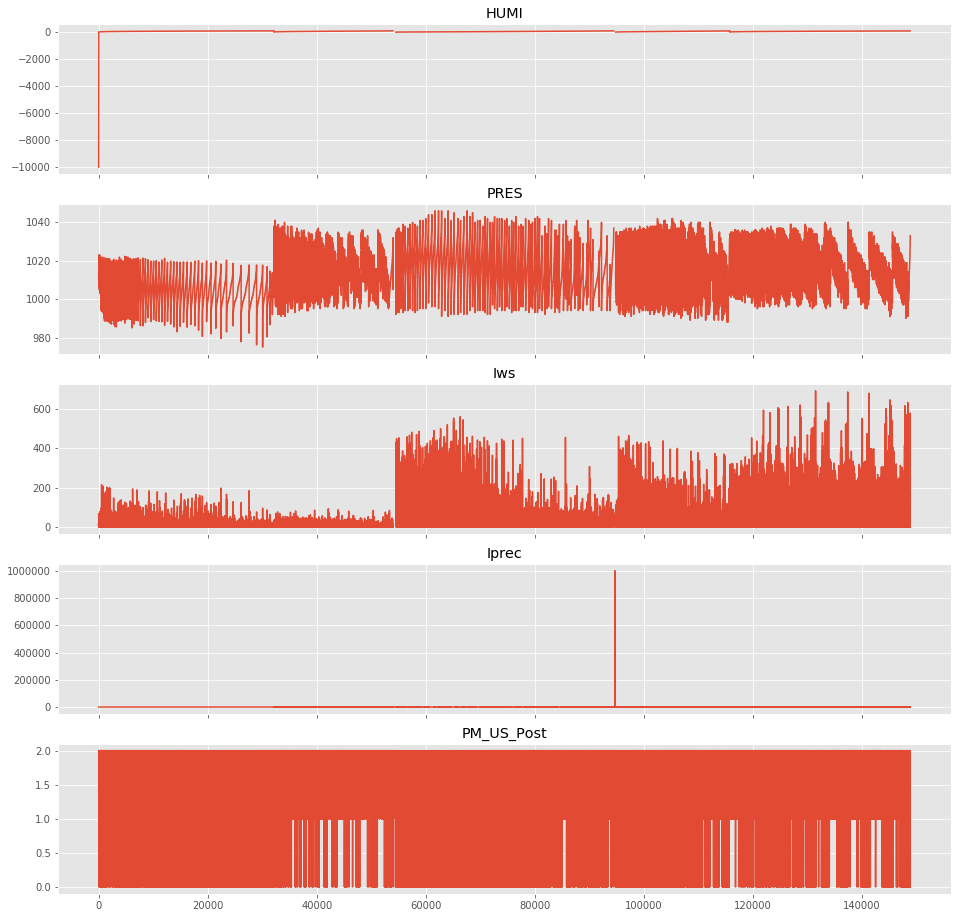

In [8]:
fig, ax = plt.subplots(rec_view.dtype.__len__(), 1, figsize = (16, 16), sharex=True)
for i, col in enumerate(rec_view.dtype.names):
    ax[i].plot(rec_view[col])
    ax[i].set_title(col)

In [9]:
# import pandas as pd
# import seaborn as sns

# df = pd.DataFrame(rec_view)
# g = sns.PairGrid(df)
# g.map_upper(plt.scatter)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.distplot)

## Count Label

In [10]:
for rec in recs:
    unique, counts = np.unique(rec['PM_US_Post'], return_counts=True)
    print(dict(zip(unique, counts)))

{0.0: 1581, 1.0: 7076, 2.0: 23488}
{0.0: 220, 1.0: 1683, 2.0: 20446}
{0.0: 2395, 1.0: 9025, 2.0: 28906}
{0.0: 758, 1.0: 3113, 2.0: 17035}
{0.0: 1585, 1.0: 6699, 2.0: 24851}


## Show NaN row

In [11]:
for rec in recs:
    view = rec.view(np.float64).reshape(-1, rec.dtype.__len__())
    print(rec[np.any(np.isnan(view), axis=1)])

[(nan, nan, nan, nan, 2.)]
[(24.18, 1020.,  5.,  nan, 2.) (26.17, 1017., nan,  0. , 1.)
 (28.14, 1016., nan,  0. , 1.) ... (  nan,   nan, nan, 17.3, 2.)
 (  nan,   nan, nan, 17.4, 2.) (  nan,   nan, nan,  nan, 2.)]
[(  6., 1013.,   7.15,        nan, 2.)
 (  7., 1014.,  16.09,        nan, 1.)
 (  8., 1009.,  92.53,        nan, 2.)
 (  8., 1016.,  30.39,        nan, 1.)
 (  9., 1010., 105.49,        nan, 2.)
 (  9., 1015.,  23.24,        nan, 1.)
 (  9., 1020.,   4.92,        nan, 1.)
 ( 10., 1018.,   3.13,        nan, 1.)
 ( 11., 1011., 115.32,        nan, 2.)
 ( 12., 1009.,   7.15,        nan, 1.)
 ( 12., 1016.,  33.53,        nan, 1.)
 ( 13., 1008.,  12.97,        nan, 2.)
 ( 13., 1011., 123.37,        nan, 2.)
 ( 14., 1013., 137.23,        nan, 2.)
 ( 14., 1016.,  15.65,        nan, 2.)
 ( 14., 1020.,  19.66,        nan, 2.)
 ( 15., 1006.,  17.88,        nan, 2.)
 ( 15., 1011.,  15.2 ,        nan, 2.)
 ( 15., 1017.,  10.73,        nan, 2.)
 ( 15., 1017.,  29.5 ,        nan, 2.)
 ( 15

## Interpolation

In [12]:
for rec in recs:
    for i, col in enumerate(rec.dtype.names[:-1]):
        indices = np.arange(rec[col].shape[0])
        not_nan = ~np.isnan(rec[col])
        rec[col] = np.interp(indices, indices[not_nan], rec[col][not_nan])

## Fill Outlier with 3SD

In [13]:
for rec in recs:
    for i, col in enumerate(rec.dtype.names[:-1]):
        upper_bound = 3*np.std(rec[col])
        cond = abs(rec[col] - np.mean(rec[col])) > upper_bound
        rec[col][cond] = upper_bound

## Moving Average

In [14]:
for rec in recs:
    for i, col in enumerate(rec.dtype.names[:-1]):
        rec[col] = np.convolve(rec[col], np.ones(2)/2, mode='same')

## Standardization Normalization

In [15]:
for rec in recs:
    for i, col in enumerate(rec.dtype.names[:-1]):
        rec[col] = (rec[col] - rec[col].mean()) / rec[col].std()

## Visualization

In [16]:
rec_view = np.concatenate(recs)

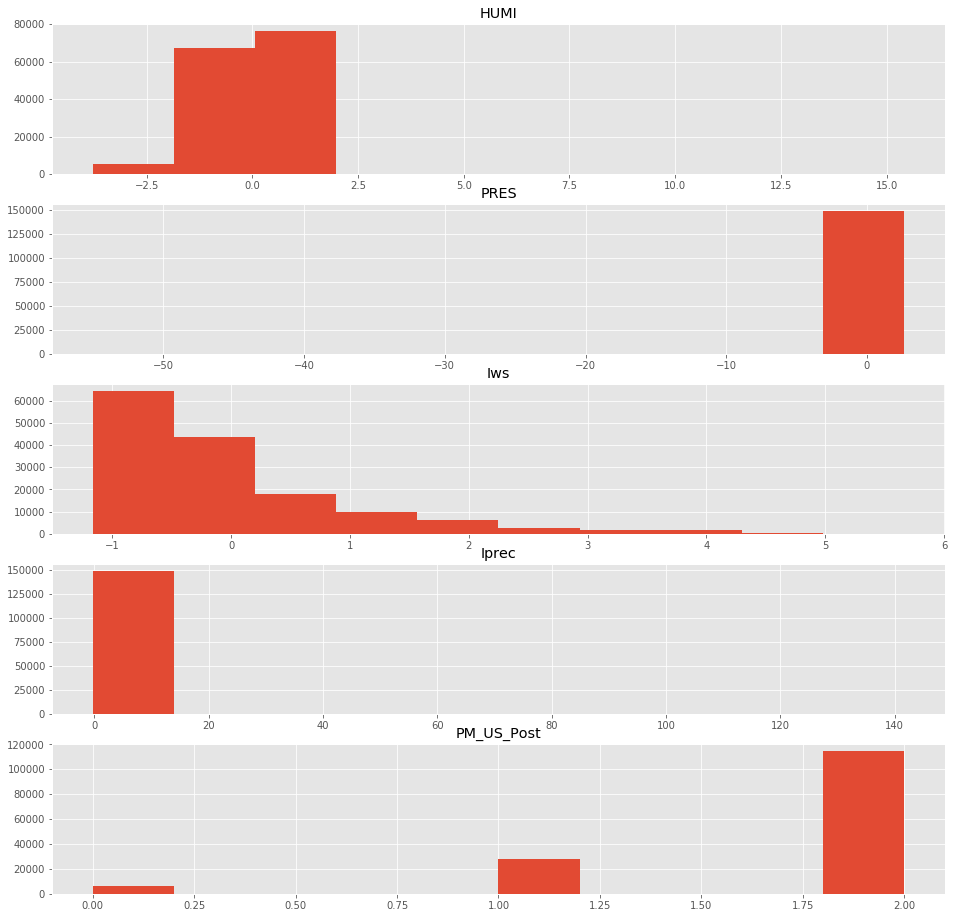

In [17]:
fig, ax = plt.subplots(rec_view.dtype.__len__(), 1, figsize = (16, 16))
for i, col in enumerate(rec_view.dtype.names):
    ax[i].hist(rec_view[col])
    ax[i].set_title(col)

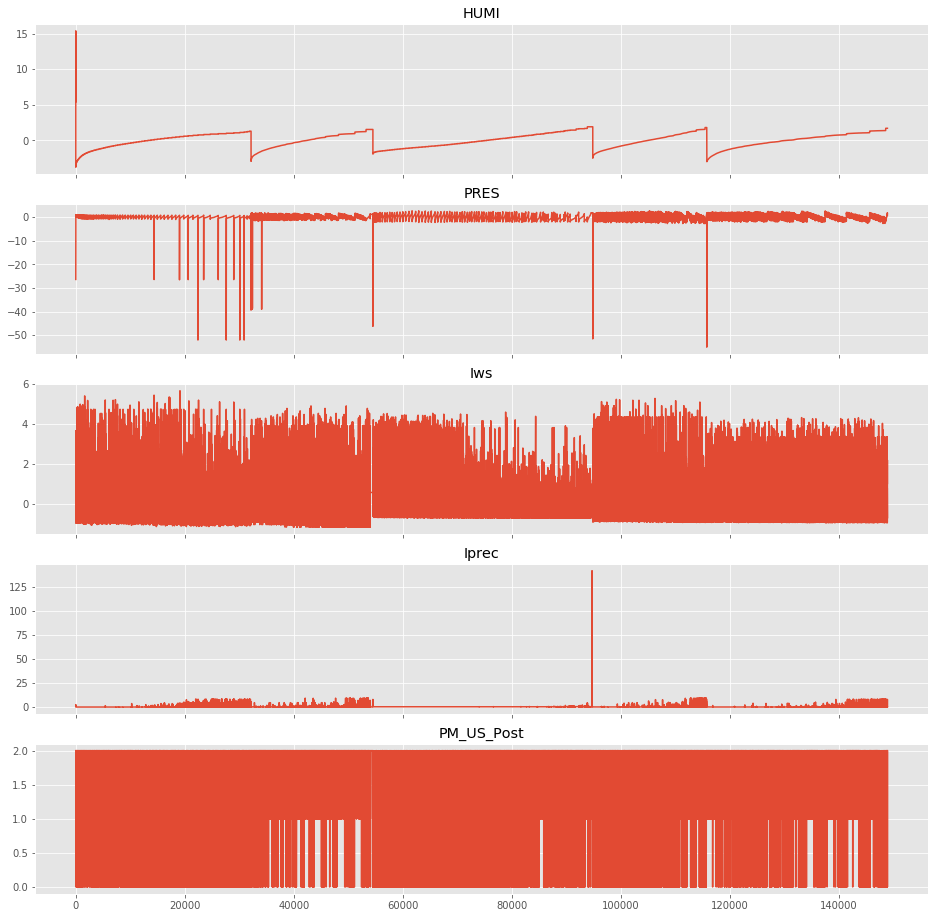

In [18]:
fig, ax = plt.subplots(rec_view.dtype.__len__(), 1, figsize = (16, 16), sharex=True)
for i, col in enumerate(rec_view.dtype.names):
    ax[i].plot(rec_view[col])
    ax[i].set_title(col)

In [19]:
# df = pd.DataFrame(rec_view)
# g = sns.PairGrid(df)
# g.map_upper(plt.scatter)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.distplot)


## Covent Time-series format

In [20]:
def create_strided(arr, step, windows):
    itemsize = np.dtype(np.float64).itemsize
    shape = ((arr.shape[0] -windows)//step +1, windows, n_feature, 1)
    strides = (step*(n_feature)*itemsize, n_feature*itemsize, itemsize, itemsize)

    arr_windows = as_strided(arr, shape=shape, strides=strides)
    return arr_windows

In [21]:
step = 16
windows = 64

rec_windows = []
rec_labels = []

for rec in recs:
    for label in labels:
        arr = repack_fields(rec[usecols[:-1]][rec['PM_US_Post'] == label]).view(np.float64).reshape(-1, n_feature)
        j = create_strided(arr, step, windows)
        rec_windows.append(j)
        rec_labels.append(np.repeat(label, j.shape[0]))

rec_windows = np.concatenate(rec_windows)
rec_labels = np.concatenate(rec_labels)

rec.shape, rec_windows.shape, rec_labels.shape

((33135,), (9252, 64, 4, 1), (9252,))

## One-Hot Encoder

In [22]:
one_hot = np.zeros((rec_labels.shape[0], 1, labels.shape[0]))
for i, unique_value in enumerate(labels):
    one_hot[:, :, i][rec_labels == unique_value] = 1

rec_labels_onehot = one_hot.reshape(-1, labels.shape[0]*1)

rec_labels_onehot.shape

(9252, 3)

## Train & Test Split

In [23]:
random_state = 0

# np.random.seed(random_state)
# np.random.shuffle(rec_windows)

# np.random.seed(random_state)
# np.random.shuffle(rec_labels_onehot)

# rec_windows.shape, rec_labels_onehot.shape

In [24]:
train_size = 0.8
# Implement stratified samples
# sample = int(train_size*rec_labels_onehot.shape[0])

# X_train, X_test = rec_windows[:sample], rec_windows[sample:]
# y_train, y_test = rec_labels_onehot[:sample], rec_labels_onehot[sample:]

# X_train.shape, X_test.shape

In [25]:
X_4d_train, X_4d_test, y_train, y_test = train_test_split(rec_windows, rec_labels_onehot, test_size=1 -train_size, random_state=random_state, stratify=rec_labels_onehot)

X_3d_train = X_4d_train.reshape(-1, windows, n_feature)
X_3d_test = X_4d_test.reshape(-1, windows, n_feature)

y_train_single = y_train.argmax(axis=1)
y_test_single = y_test.argmax(axis=1)

X_4d_train.shape, X_4d_test.shape, y_train.shape, y_test.shape

((7401, 64, 4, 1), (1851, 64, 4, 1), (7401, 3), (1851, 3))

## CNN Model

In [26]:
def create_cnn(input_shape=X_4d_train.shape[1:], num_classes=y_train.shape[1],
               conv=(128, 128, 64), conv_drop=(0.2, 0.2),
               kernel_size=(3, 3), pool_size=(2, 2), strides=(2, 2),
               dense=(128, 128), dense_dropout=(0.2, 0.2),
               activation='relu',
               optimizer='adam',
               lr=0.001, beta_1=0.9, beta_2=0.99):
    model = Sequential()

    model.add(Conv2D(conv[0], kernel_size=kernel_size, activation=activation, padding='same', input_shape=input_shape))
    model.add(Conv2D(conv[1], kernel_size=kernel_size, activation=activation, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
    model.add(Dropout(conv_drop[0]))
    
    model.add(Conv2D(conv[2], kernel_size=kernel_size, activation=activation, padding='same'))
    model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
#     model.add(Dropout(conv_drop[1]))

    model.add(Flatten())

    model.add(Dense(dense[0], activation=activation))
    model.add(Dropout(dense_dropout[0]))

    model.add(Dense(dense[1], activation=activation))
    model.add(Dropout(dense_dropout[1]))

    model.add(Dense(num_classes, activation='sigmoid'))
    
#     optimizer = Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2, amsgrad=False)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

cnn = create_cnn()
cnn.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 4, 128)        1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 4, 128)        147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 4, 128)        512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 2, 128)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 2, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 2, 64)         73792     
____

In [27]:
def create_lstm(input_shape=X_3d_train.shape[1:], num_classes=y_train.shape[1],
                dense=(128, 128, 128), dense_dropout=(0.2, 0.2, 0.2),
                activation='relu',
                optimizer='adam',
                lr=0.001, beta_1=0.9, beta_2=0.99):
    model = Sequential()

    model.add(LSTM(dense[0], activation=activation, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(dense_dropout[0]))

    model.add(LSTM(dense[1], activation=activation, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(dense_dropout[1]))
    
    model.add(LSTM(dense[2], activation=activation))
    model.add(BatchNormalization())
#     model.add(Dropout(dense_dropout[2]))

    model.add(Dense(num_classes, activation='sigmoid'))

#     optimizer = Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2, amsgrad=False)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

lstm = create_lstm()
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64, 128)           68096     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 128)           512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 128)           131584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 128)           512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)              

## Train

In [28]:
cnn_batch_size = 512
cnn_epochs = 32

cnn = create_cnn()
cnn_history = cnn.fit(X_4d_train, y_train, batch_size=cnn_batch_size, epochs=cnn_epochs, validation_data=(X_4d_test, y_test))

Train on 7401 samples, validate on 1851 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/32
7401/7401 [==============================] - 2s 312us/sample - loss: 0.5964 - acc: 0.7476 - val_loss: 0.7097 - val_acc: 0.7844
Epoch 2/32
7401/7401 [==============================] - 1s 88us/sample - loss: 0.3433 - acc: 0.8596 - val_loss: 0.6108 - val_acc: 0.7736
Epoch 3/32
7401/7401 [==============================] - 0s 60us/sample - loss: 0.2652 - acc: 0.8837 - val_loss: 0.9606 - val_acc: 0.7731
Epoch 4/32
7401/7401 [==============================] - 0s 59us/sample - loss: 0.2244 - acc: 0.8974 - val_loss: 1.4268 - val_acc: 0.7731
Epoch 5/32
7401/7401 [==============================] - 0s 57us/sample - loss: 0.1972 - acc: 0.9079 - val_loss: 1.8293 - val_acc: 0.7731
Epoch 6/32
7401/7401 [==============================] - 0s 58us/sample - loss: 0.1769 - acc: 0.9170 - val_loss: 2.3108 - val_acc: 0.7731
Epoch 7/32
7401/7401 [=============

In [29]:
lstm_batch_size = 256
lstm_epochs = 16

lstm = create_lstm()
lstm_history = lstm.fit(X_3d_train, y_train, batch_size=lstm_batch_size, epochs=lstm_epochs, validation_data=(X_3d_test, y_test))

Train on 7401 samples, validate on 1851 samples
Epoch 1/16
7401/7401 [==============================] - 10s 1ms/sample - loss: 1.0925 - acc: 0.5742 - val_loss: 0.9766 - val_acc: 0.7726
Epoch 2/16
7401/7401 [==============================] - 8s 1ms/sample - loss: 0.9749 - acc: 0.6773 - val_loss: 0.8699 - val_acc: 0.7731
Epoch 3/16
7401/7401 [==============================] - 8s 1ms/sample - loss: 0.8390 - acc: 0.6818 - val_loss: 0.7546 - val_acc: 0.7731
Epoch 4/16
7401/7401 [==============================] - 8s 1ms/sample - loss: 0.7502 - acc: 0.7119 - val_loss: 0.6774 - val_acc: 0.7731
Epoch 5/16
7401/7401 [==============================] - 8s 1ms/sample - loss: 0.6952 - acc: 0.7322 - val_loss: 0.6512 - val_acc: 0.7731
Epoch 6/16
7401/7401 [==============================] - 8s 1ms/sample - loss: 0.6657 - acc: 0.7423 - val_loss: 0.6448 - val_acc: 0.7731
Epoch 7/16
7401/7401 [==============================] - 8s 1ms/sample - loss: 0.6495 - acc: 0.7494 - val_loss: 0.6455 - val_acc: 0.7731

## Training accuracy and Training Loss Graph

### CNN

Text(0, 0.5, 'Training loss')

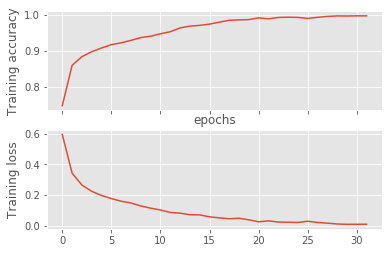

In [30]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(cnn_history.history['acc'], label=cnn)
ax[1].plot(cnn_history.history['loss'], label=cnn)
 
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Training accuracy')
ax[1].set_ylabel('Training loss')

### LSTM

Text(0, 0.5, 'Training loss')

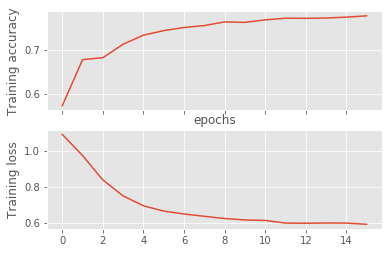

In [31]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(lstm_history.history['acc'], label=lstm)
ax[1].plot(lstm_history.history['loss'], label=lstm)
 
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Training accuracy')
ax[1].set_ylabel('Training loss')

## Evaluate

In [32]:
cnn_score = cnn.evaluate(X_4d_test, y_test)
lstm_score = lstm.evaluate(X_3d_test, y_test)

cnn_score, lstm_score

1851/1851 [==============================] - 5s 3ms/sample - loss: 0.6407 - acc: 0.7736


([1.0835419845917509, 0.86925983], [0.6407171092698022, 0.77363586])

## Classification Report

In [33]:
cnn_pred = cnn.predict_classes(X_4d_test)
lstm_pred = lstm.predict_classes(X_3d_test)

print('CNN')
print(np.bincount(y_test_single*n_classes +cnn_pred).reshape((n_classes, n_classes)))
print('LSTM')
print(np.bincount(y_test_single*n_classes +lstm_pred).reshape((n_classes, n_classes)))

CNN
[[   4   64   10]
 [   0  175  167]
 [   0    1 1430]]
LSTM
[[   1    0   77]
 [   0    0  342]
 [   0    0 1431]]


## Confusion Matrix

In [34]:
print('CNN')
print(classification_report(y_test_single, cnn_pred))
print('LSTM')
print(classification_report(y_test_single, lstm_pred))

CNN
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        78
           1       0.73      0.51      0.60       342
           2       0.89      1.00      0.94      1431

    accuracy                           0.87      1851
   macro avg       0.87      0.52      0.55      1851
weighted avg       0.86      0.87      0.84      1851

LSTM
              precision    recall  f1-score   support

           0       1.00      0.01      0.03        78
           1       0.00      0.00      0.00       342
           2       0.77      1.00      0.87      1431

    accuracy                           0.77      1851
   macro avg       0.59      0.34      0.30      1851
weighted avg       0.64      0.77      0.68      1851



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# GridSearch

## Cross Validation

In [35]:
n_splits = 2

skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

In [36]:
param_grid_cnn = {
#     'neurons': [(16, 16), (32, 32)],
#     'lr': [0.01, 0.1],
#     'batch_size': [16, 32],
#     'epochs': [8, 16],
#     'optimizer': ['adam', 'adadelta'],
}

param_grid_lstm = {
#     'neurons': [(16, 16), (32, 32)],
#     'lr': [0.01, 0.1],
#     'batch_size': [16, 32],
#     'epochs': [8, 16],
#     'optimizer': ['adam', 'adadelta'],
}

In [37]:
cnn_keras = KerasClassifier(build_fn=create_cnn, verbose=1)
lstm_keras = KerasClassifier(build_fn=create_lstm, verbose=1)

gsCV_cnn = GridSearchCV(estimator=cnn_keras, param_grid=param_grid_cnn, scoring='accuracy', n_jobs=1, cv=skfold)
gsCV_lstm = GridSearchCV(estimator=lstm_keras, param_grid=param_grid_cnn, scoring='accuracy', n_jobs=1, cv=skfold)

## Train

In [38]:
gsCV_cnn.fit(X_4d_train, y_train_single, validation_data=(X_4d_test, y_test))

Train on 3700 samples, validate on 1851 samples
3701/3701 [==============================] - 0s 90us/sample
Train on 3701 samples, validate on 1851 samples
3700/3700 [==============================] - 0s 83us/sample
Train on 7401 samples, validate on 1851 samples
7401/7401 [==============================] - 2s 302us/sample - loss: 0.3981 - acc: 0.8461 - val_loss: 0.9312 - val_acc: 0.7742


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=0, shuffle=True),
             error_score='raise-deprecating',
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fd01c430e48>,
             iid='warn', n_jobs=1, param_grid={}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='accuracy',
             verbose=0)

In [39]:
gsCV_lstm.fit(X_3d_train, y_train_single, validation_data=(X_3d_test, y_test))

Train on 3700 samples, validate on 1851 samples
3701/3701 [==============================] - 11s 3ms/sample
Train on 3701 samples, validate on 1851 samples
3700/3700 [==============================] - 11s 3ms/sample
Train on 7401 samples, validate on 1851 samples
7401/7401 [==============================] - 69s 9ms/sample - loss: 0.9028 - acc: 0.6130 - val_loss: 0.6534 - val_acc: 0.7731


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=0, shuffle=True),
             error_score='raise-deprecating',
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fd01c430ac8>,
             iid='warn', n_jobs=1, param_grid={}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='accuracy',
             verbose=0)

## Best Score CNN

In [40]:
print('best score: ', gsCV_cnn.best_score_, gsCV_cnn.best_params_)

means = gsCV_cnn.cv_results_['mean_test_score']
stds = gsCV_cnn.cv_results_['std_test_score']
params = gsCV_cnn.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'{mean} ({stdev}) with: {param}')

best score:  0.7731387650317525 {}
0.7731387650317525 (0.00010446409567476471) with: {}


## Best Score LSTM

In [41]:
print('best score: ', gsCV_lstm.best_score_, gsCV_lstm.best_params_)

means = gsCV_lstm.cv_results_['mean_test_score']
stds = gsCV_lstm.cv_results_['std_test_score']
params = gsCV_lstm.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'{mean} ({stdev}) with: {param}')

best score:  0.7731387650317525 {}
0.7731387650317525 (0.00010446409567476471) with: {}


## Classification Report

In [42]:
cnn_pred = gsCV_cnn.predict(X_4d_test)
lstm_pred = gsCV_lstm.predict(X_3d_test)

print('CNN')
print(classification_report(y_test_single, cnn_pred))
print('LSTM')
print(classification_report(y_test_single, lstm_pred))

1851/1851 [==============================] - 6s 3ms/sample
CNN
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.25      0.01      0.01       342
           2       0.78      1.00      0.87      1431

    accuracy                           0.77      1851
   macro avg       0.34      0.34      0.30      1851
weighted avg       0.65      0.77      0.68      1851

LSTM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.00      0.00      0.00       342
           2       0.77      1.00      0.87      1431

    accuracy                           0.77      1851
   macro avg       0.26      0.33      0.29      1851
weighted avg       0.60      0.77      0.67      1851



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Confusion Matrix

In [43]:
print('CNN')
print(np.bincount(y_test_single*n_classes +cnn_pred).reshape((n_classes, n_classes)))
print('LSTM')
print(np.bincount(y_test_single*n_classes +lstm_pred).reshape((n_classes, n_classes)))

CNN
[[   0    6   72]
 [   0    2  340]
 [   0    0 1431]]
LSTM
[[   0    0   78]
 [   0    0  342]
 [   0    0 1431]]
